# Notebook 04 - Het eerste model (Baseline)

We gaan nu 04_model_training_baseline.ipynb maken.
Het doel van dit notebook is niet om meteen het beste model te hebben, maar om een "Nulmeting" (Baseline) te doen. We bouwen een simpel "Convolutioneel Neuraal Netwerk" (zoals op Slide 14 gevraagd) en kijken wat er gebeurt.

## Imports en setop

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

# Check of GPU beschikbaar is 
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Paden instellen
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "datasets" / "processed"

TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "validation"
TEST_DIR = DATA_DIR / "test"

TensorFlow version: 2.20.0
GPU Available: False


## Data inladen

We gebruiken image_dataset_from_directory. Dit is de moderne manier om data efficiënt in te laden. We verkleinen afbeeldingen naar 224x224 pixels (standaardmaat voor veel AI-modellen).

In [3]:
# Instellingen
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

print("--- Training Data ---")
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DIR,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

print("\n--- Validation Data ---")
val_ds = tf.keras.utils.image_dataset_from_directory(
  VAL_DIR,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

print("\n--- Test Data ---")
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_DIR,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

# Namen van de klassen opslaan
class_names = train_ds.class_names
print(f"\nKlassen: {class_names}")
num_classes = len(class_names)

--- Training Data ---
Found 1891 files belonging to 4 classes.

--- Validation Data ---
Found 408 files belonging to 4 classes.

--- Test Data ---
Found 409 files belonging to 4 classes.

Klassen: ['Mondriaan', 'Picasso', 'Rembrandt', 'Rubens']


## Perfomance optimalisatie

Dit stukje code zorgt dat de data in het geheugen gebufferd wordt, zodat je grafische kaart (of CPU) niet hoeft te wachten op het inladen van bestanden.

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Het eerste model

it is het model gebaseerd op het boek (Hoofdstuk 8) en Slide 14.
Het bestaat uit:
1. Rescaling: Waarden van 0-255 omzetten naar 0-1.
2. Conv2D & MaxPooling: Lagen die patronen (lijnen, vormen) herkennen.
3. Flatten & Dense: Het uiteindelijke classificeren.

In [5]:
model = Sequential([
  # 1. Normalisatie (pixels van 0-255 naar 0-1)
  layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  
  # 2. Convolutie lagen (Feature extraction)
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  # 3. Classificatie lagen
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax') # Softmax voor meer dan 2 klasses
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

c:\Users\vande\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,446,756 (24.59 MB)

 Trainable params: 6,446,756 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

## Trainen

We trainen nu voor 10 epochs (rondes). Op je laptop duurt dit misschien een paar minuten. Op de VSC straks doen we er 50 of 100.

In [6]:
epochs = 10

# We slaan het resultaat op in 'history' om grafieken te maken
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step - accuracy: 0.5849 - loss: 1.1554 - val_accuracy: 0.6789 - val_loss: 0.8421
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.7282 - loss: 0.7185 - val_accuracy: 0.7623 - val_loss: 0.6272
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 202ms/step - accuracy: 0.8276 - loss: 0.4772 - val_accuracy: 0.8064 - val_loss: 0.5986
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step - accuracy: 0.8926 - loss: 0.3158 - val_accuracy: 0.8260 - val_loss: 0.5575
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - accuracy: 0.9207 - loss: 0.2369 - val_accuracy: 0.7917 - val_loss: 0.6091
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 201ms/step - accuracy: 0.9551 - loss: 0.1434 - val_accuracy: 0.7868 - val_loss: 0.6362
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 202ms/step - accuracy: 0.9736 - loss: 0.0917 - val_accuracy: 0.8407 - val_loss: 0.7166
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 200ms/step - accuracy: 0.9566 - loss: 0.1263 - val_accu

## Resultaten visualiseren

Dit is essentieel voor je verslag. Je moet laten zien of het model "Overfit" (goed op training, slecht op validatie).

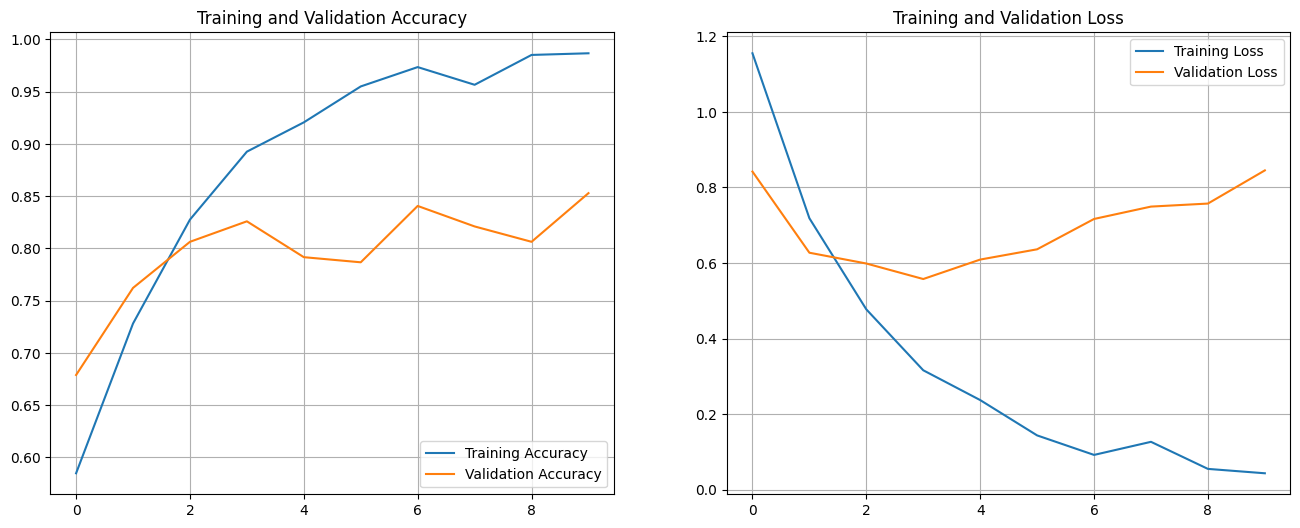

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)

plt.show()